In [4]:
# Some standard import statements that are nice for Jupyter

import sys
import os
import logging
import ipynb
import decimal

import numpy as np

from scipy.optimize import curve_fit

from IPython import get_ipython
ipython = get_ipython()
ipython.magic('load_ext autoreload')
ipython.magic('autoreload 2')
ipython.magic('matplotlib inline')

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

import time

from ipynb.fs.defs.sD2_surface_degradation import *

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Proton Beam Fluctuations

This data is coming from Edgard, somehow he had access to higher frequency (0.5 Hz vs 0.1 Hz) current readings than what Bernhard had on file at PSI. We expect to see large fluctuations corresponding to where we have missing runs in the data that Edgard had pre-processed. 

The plot from his slides is shown below. Here I believe he is showing the proton beam timing data, which Bernhard refers to with skepticism in his email:

>2RGQ00CE006   -  this is the proton beam current towards UCN - you can see when pulses appeared<br/>
but you cannot trust the absolute value for various reasons - so do notu se as monitoring detector

![](../misc/p_beam_fluctuate.png)
![](jonahberean/psi_transmission/misc/p_beam_fluctuate.png)

Edgard did provide us with the absolute value data, refered to by Bernhard as:

>2RGQ00CE004      this is the proton beam current which you can use for monitoring <br/>
this detector measures the proton beam current at the exit of the cyclotron

## Plotting All Proton Beam Data

Below all of the proton beam monitoring data are plotted.

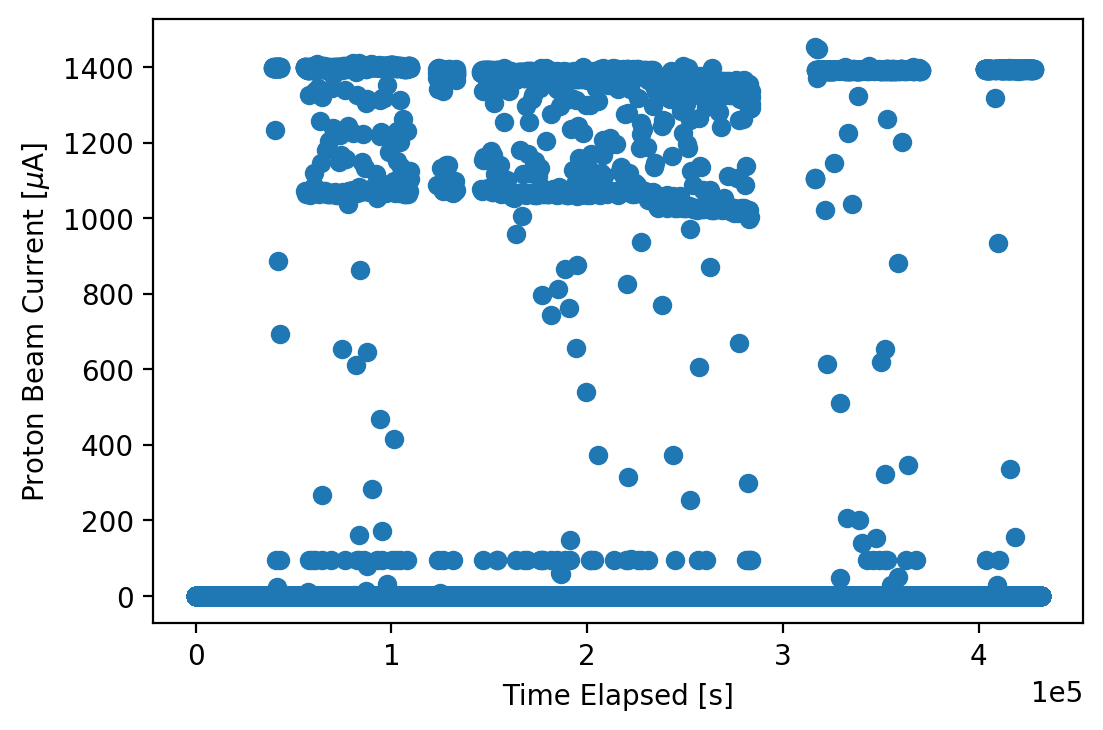

In [8]:
###############################################################################

# the time, t=0, is defined as the time of the first available proton beam 
# monitor measurement
# the retrieval of this time, as a UNIX epoch time stamp, is functionalized 
# for later use

def get_first_p_beam_time():
    """Retrieves the UNIX epoch time stamp of the first proton beam monitor 
        measurement
    
    Returns:
        first_p_beam_time (int): the UNIX epoch time stamp of the first 
            proton beam monitor measurement
    """
    
    # read the 8th of December data as a list of strings
    f = open('../data_p_beam_from_edgard/20171208.csv')
    lines = f.readlines()
    f.close()
    
    # convert the measurement time to epoch time
    date_time = lines[0][0:10] + ' ' + lines[0][11:19]
    pattern = '%Y/%m/%d %H:%M:%S'
    first_p_beam_time = int(time.mktime(time.strptime(date_time, pattern)))
    
    
    return first_p_beam_time

###############################################################################

# it will be useful to have a function that loads all of the csv data into a
# a single array 

def load_p_beam_data():
    """Loads all of the proton beam data into an array
    
    Returns:
        p_beam_data (numpy.float64): a (2 x n) array of all of the proton beam 
            monitoring data. 
                - row 0: time elapsed in seconds since the first measurement
                - row 1: beam current in uA
    """
    
    # instantiate array to hold the resulting data, empty and single column 
    # at first, for data to be successively stacked
    p_beam_data = np.zeros(2)
    
    # retrieve the first measurement's time stamp
    first_p_beam_time = get_first_p_beam_time()
    
    # loop through the files and load the data
    for filename in os.listdir('../data_p_beam_from_edgard'):
        
        # all of the csv file is converted to a list of strings for extracting
        # the time data
        f = open('../data_p_beam_from_edgard/' + filename)
        lines = f.readlines()
        f.close()
        
        # instantiate an array to hold the measurement times
        times = np.zeros(np.shape(lines)[0])
        
        # loop over every row in the csv file
        for i in range(0, np.shape(lines)[0]):
            
            # convert the measurement time to epoch time
            date_time = lines[i][0:10] + ' ' + lines[i][11:19]
            pattern = '%Y/%m/%d %H:%M:%S'
            measurement_time = int(
                time.mktime(time.strptime(date_time, pattern)))
            
            # save the elapsed time to the times array
            times[i] = measurement_time - first_p_beam_time
        
        # the current data is loaded into a numpy array
        data = np.loadtxt('../data_p_beam_from_edgard/' + filename, 
                          delimiter = '\t', usecols=(2));
        
        # join the time and current data together
        joined_array = np.vstack((times, data))

        # if this is the first file to be read, then set the p_beam_data
        # variable equal to the joined array. 
        if(np.size(p_beam_data) == 2):
            
            p_beam_data = joined_array
            
        # otherwise stack the new data below the existing one
        else:
            
            p_beam_data = np.hstack((p_beam_data, joined_array))
    
    return p_beam_data

###############################################################################

# load the proton beam data
p_beam_data = load_p_beam_data()

# plot all of the proton beam data
plt.scatter(p_beam_data[0,:], p_beam_data[1,:])
plt.xlabel('Time Elapsed [s]');
plt.ylabel(r'Proton Beam Current [$\mu$A]');
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

Nothing to parse just yet, but that's the full data set.

## Cross-Referencing the Proton Beam Current Data with Absolute UCN Detected Counts

The main detector run data files that we got from Edgard largely match what we see in the elog, meaning that his selection of runs based on cyclotron fluctuations was probably predictable during the beam time. Here we will be looking for large fluctuations of the neutron counts from individual runs, and we want to see those fluctuations in the context of fluctuating proton beam currents. 

We're expecting neutron transmission values through the guides of ~0.5-0.9, so for a preliminary analysis we can go ahead and look at the counts without any configuration-dependent re-normalization of the total count rates. However, a re-normalization of all the data according to time elapsed - since the first experimental run - will be performed to account for the decline in absolute UCN counts over time. 

Here are the preliminary results for transmission from Edgard, as justification for my rough approach:

![](../misc/triumf_guide_transmission.png)
![](jonahberean/psi_transmission/misc/triumf_guide_transmission.png)

![](../misc/jp_guide_transmission.png)
![](jonahberean/psi_transmission/misc/jp_guide_transmission.png)

### Reviewing the Normalization to Absolute UCN Detection Degradation

The latest work on these measurements are contained in the 'sD2_surface_degradation' notebook. Here is a quick review of what I'm using, for utility of presentation.

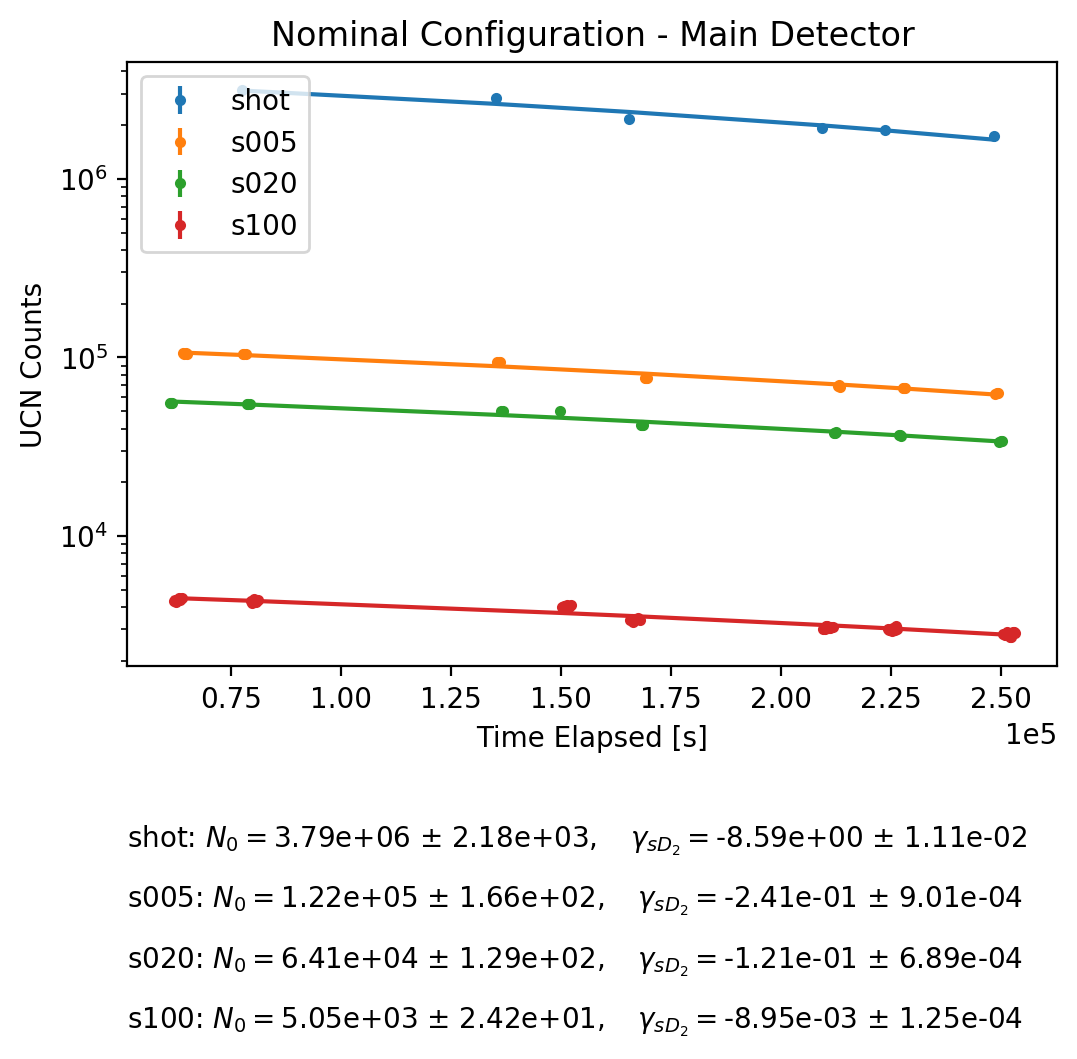

In [10]:
###############################################################################

# the full function for loading nominal configuration data is defined in the
# aforementioned, other notebook.

###############################################################################

Here the fit function is a simple linear model, 

$$N(t) = N_0 - \gamma_{sD_2} t$$

where $N_0$ would be the extrapolated number of counts for a hypothetical storage time at $t=0$. Here we define the $t=0$ time to be the start of the proton beam current measurements, which is appropriate for the comparisons to be made in this notebook. The parameter $\gamma_{sD_2}$ is the loss rate of absolute UCN counts over time. Here the lowercase $\gamma$ is used to differentiate this rate from the characteristic decay rate $\Gamma$ of a single UCN.

The four independent fits shown above are used to normalize every run of the matching pre-storage time, in all configurations.

### Plotting every Main Detector Run with the Proton Beam Current Data

Next we can take the normalized main detector data from every run, and plot it alongside the proton beam current data. To start, we'll use only those runs that were accepted by Edgard (even less than this really, as I also made some cuts from what was available after reviewing the elog).

In [ ]:
# load the proton beam data
p_beam_data = load_p_beam_data()

# plot all of the proton beam data
plt.scatter(p_beam_data[0,:], p_beam_data[1,:])
plt.xlabel('Time Elapsed [s]');
plt.ylabel(r'Proton Beam Current [$\mu$A]');
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# 